#Данные

In [ ]:
import csv

In [ ]:
import numpy as np

In [ ]:
data = []
with open('/content/data_v1-06.csv') as f:
    reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC)
    for row in reader: # each row is a list
        data.append(row)
data = np.array(data)

In [ ]:
data.shape

(80, 2)

#Кросс-валидация: Holdout (70/30)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_data, test_data = train_test_split(data, train_size=0.7, random_state=31)

In [ ]:
train_data.shape[0] == data.shape[0]*0.7

True

##Транспонирование данных

In [ ]:
data = np.transpose(data)
train_data = np.transpose(train_data)
test_data = np.transpose(test_data)
print(data.shape)

(2, 80)


##Картиночка

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 45})

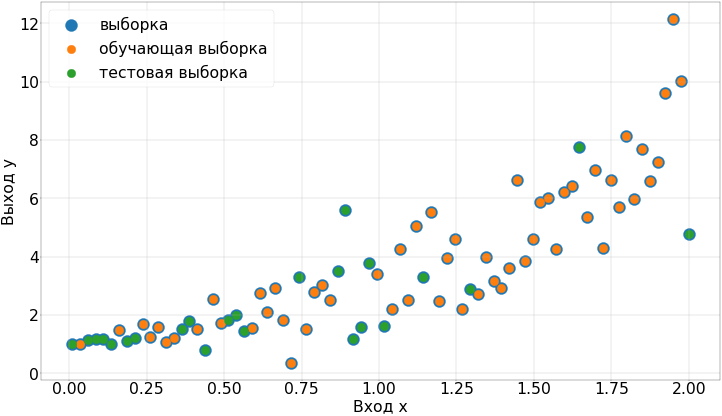

In [ ]:
fig, ax = plt.subplots()

plt.scatter(data[0],data[1], s=12e2, label='выборка')
plt.scatter(train_data[0],train_data[1], s=6e2, label='обучающая выборка')
plt.scatter(test_data[0],test_data[1], s=6e2, label='тестовая выборка')
plt.legend(loc='upper left')
plt.grid(True)
plt.xlabel('Вход x')
plt.ylabel('Выход y')
ax.legend()
fig.set_figwidth(35)
fig.set_figheight(20)
fig.set_dpi(25)
None

#Задание 1

#Невзвешенный МНК (OLS)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
OLS = LinearRegression(n_jobs=4)

In [ ]:
OLS.fit(X=train_data[0].reshape(-1, 1), y=train_data[1])

LinearRegression(n_jobs=4)

In [ ]:
OLS.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': 4,
 'normalize': 'deprecated',
 'positive': False}

In [ ]:
params_OLS = np.array([OLS.coef_[0], OLS.intercept_])
params_OLS

array([ 3.87688716, -0.3637846 ])

In [ ]:
def regression(x, params):
  return params[0]*x+params[1]

##Коэффициент детерминации $R^{2^{*}}$  
$R_{Y|X}^{2^{*}} = \frac{D_{регр\ Y|X}}{D_{Y}}=1-\frac{D_{ост\ Y}^*}{D_{Y}^*}$  
${D_{ост\ Y}^*} = \bar{\tilde{\varepsilon}}^2 = \frac{1}{n}\sum\limits_{i=1}^n(y_i-\tilde{f}(x_i,\beta_0, \beta_1))^2$

In [ ]:
def residuals(y, y_model):
  return y-y_model

In [ ]:
def R_sqr(x,y,params):
  e = residuals(y, regression(x, params))
  D_e = np.sum(e**2)/len(e)
  D_y = np.var(y)
  return 1-(D_e/D_y)

In [ ]:
print(R_sqr(train_data[0], train_data[1], params_OLS), R_sqr(test_data[0], test_data[1], params_OLS))

0.7164752370236529 0.4061659559944105


##Доверительные интервалы для функции регрессии  
$\displaystyle\tilde{f}(x)\pm t_{\alpha/2}(n-2)\sqrt{\tilde{D}_{ост\ Y}}\sqrt{\frac{1}{n}+\frac{(x-\bar{x})^2}{nD^*_X}}$,  
где $t_{\alpha/2}(n-2)$ - квантиль распределения Стьюдента с $n–2$ степенями свободы на уровне $1–\alpha/2$,  
$D^*_X$ – выборочная дисперсия случайной величины X,  
$\tilde{D}_{ост\ Y}$ – несмещённая оценка остаточной дисперсии случайной величины Y:  
$\tilde{D}_{ост\ Y} = \frac{1}{n-2}\sum\limits_{i=1}^n(y_i-\tilde{f}(x_i,\beta_0, \beta_1))^2$

In [ ]:
from scipy.stats import t

In [ ]:
def D_res_nonbias(x, y, params):
  e = residuals(y, regression(x, params))
  D_e = np.sum(e**2)/len(e-len(params))
  return D_e

In [ ]:
def confidence_interval(point,alpha,x,y,params):
  n = len(x)
  k = len(params)
  tt = t.ppf(1-alpha/2, n-k)
  add = tt*np.sqrt(D_res_nonbias(x,y,params))*np.sqrt(1/n + ((point-x.mean())**2)/(n*x.var()))
  f = regression(point, params)
  return [f-add, f+add]

In [ ]:
conf_interval_90 = []
conf_interval_99 = []
conf_interval_points = np.linspace(data[0].min(), data[0].max(), 300)
# conf_interval_points = np.linspace(-10, 10, 500)
for point in conf_interval_points:
  conf_interval_90.append(confidence_interval(point,0.9,test_data[0],test_data[1],params_OLS))
  conf_interval_99.append(confidence_interval(point,0.99,test_data[0],test_data[1],params_OLS))

In [ ]:
conf_interval_90 = np.array(conf_interval_90).transpose()
conf_interval_99 = np.array(conf_interval_99).transpose()

##Картиночка

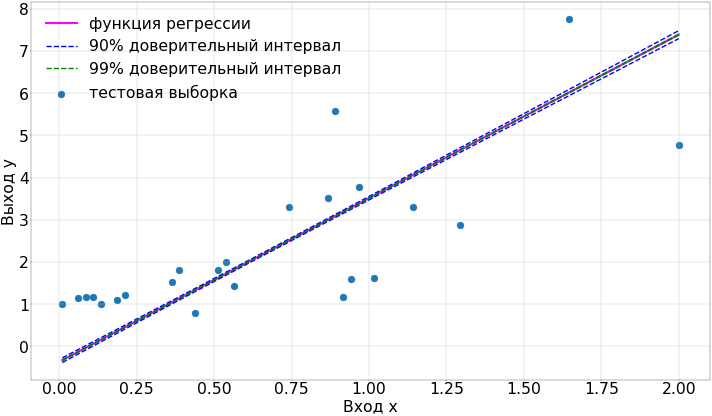

In [ ]:
plt.figure(figsize=(35, 20), dpi=25)
plt.scatter(test_data[0],test_data[1], s=4e2, label='тестовая выборка')
# plt.scatter(train_data[0],train_data[1], label='обучающая выборка')
xx = np.array([test_data[0].min(), test_data[0].max()])
yy = regression(xx, params_OLS)
plt.plot(xx, yy, c='magenta', label='функция регрессии', linewidth=6)
plt.plot(conf_interval_points, conf_interval_90[0], 'b--', linewidth=4, label='90% доверительный интервал')
plt.plot(conf_interval_points, conf_interval_90[1], 'b--', linewidth=4)
plt.plot(conf_interval_points, conf_interval_99[0], 'g--',  linewidth=4, label='99% доверительный интервал')
plt.plot(conf_interval_points, conf_interval_99[1], 'g--', linewidth=4)
plt.xlabel('Вход x')
plt.ylabel('Выход y')
plt.grid(True)
plt.legend(framealpha=0)

#Остатки

#Задание 2

##Зависимость остатков от моделируемых значений и входной переменной

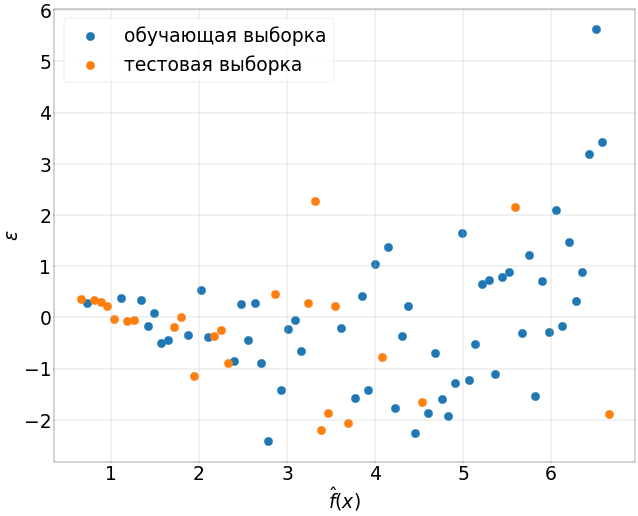

In [ ]:
plt.figure(figsize=(25, 20), dpi=30)
y_model_train = regression(train_data[0], params_OLS)
res_train = residuals(train_data[1],y_model_train)
plt.scatter(y_model_train, res_train, s=4e2, label = 'обучающая выборка')

y_model_test = regression(test_data[0], params_OLS)
res_test = residuals(test_data[1],y_model_test)
plt.scatter(y_model_test, res_test, s=4e2, label = 'тестовая выборка')

plt.ylabel(r'$\varepsilon$')
plt.xlabel(r'$\hat{f}(x)$')
plt.legend(loc='upper left')
plt.grid(True)

In [ ]:
s = 4e2

In [ ]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_goldfeldquandt

In [ ]:
het_goldfeldquandt(train_data[1].reshape(56,1), train_data[0].reshape(56,1))

(0.8574683257074452, 0.6538127453034941, 'increasing')

In [ ]:
het_goldfeldquandt(test_data[1].reshape(24,1), test_data[0].reshape(24,1))

(0.4442194990797993, 0.9029292067237856, 'increasing')

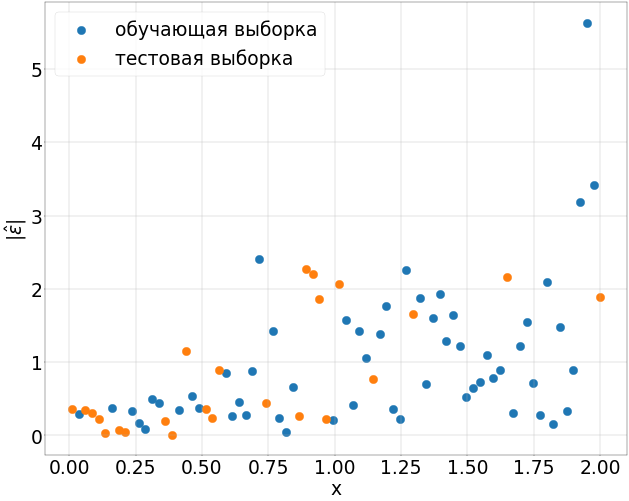

In [ ]:
plt.figure(figsize=(25, 20), dpi=30)
abs_res_train = np.abs(residuals(train_data[1],y_model_train))
plt.scatter(train_data[0], abs_res_train, s=s, label = 'обучающая выборка')

abs_res_test = np.abs(residuals(test_data[1],y_model_test))
plt.scatter(test_data[0], abs_res_test, s=s, label = 'тестовая выборка')

plt.ylabel(r'$|\hat{\varepsilon}|$')
plt.xlabel('x')
plt.legend(loc='upper left')
plt.grid(True)

#Задание 3

##Анализ гетероскедастичности остатков

In [ ]:
y_model_train = regression(train_data[0], params_OLS)
abs_res_train = np.abs(residuals(train_data[1],y_model_train))
y_model_test = regression(test_data[0], params_OLS)
abs_res_test = np.abs(residuals(test_data[1],y_model_test))

In [ ]:
model_e = LinearRegression()

model_e.fit(train_data[0].reshape(-1,1), abs_res_train)
e_params_train = np.array([model_e.coef_[0], model_e.intercept_])

model_e.fit(test_data[0].reshape(-1,1), abs_res_test)
e_params_test = np.array([model_e.coef_[0], model_e.intercept_])

In [ ]:
print(e_params_train, e_params_test)

[0.50836178 0.44001871] [0.70983393 0.63309519]


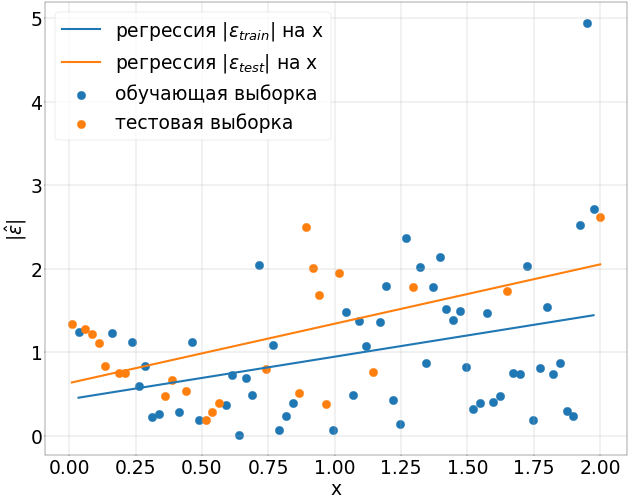

In [ ]:
plt.figure(figsize=(25, 20), dpi=30)

plt.scatter(train_data[0], abs_res_train, s=s, label = 'обучающая выборка')
plt.scatter(test_data[0], abs_res_test, s=s,  label = 'тестовая выборка')

xx_train = np.array([train_data[0].min(), train_data[0].max()])
ee_train = regression(xx_train, e_params_train)

xx_test = np.array([test_data[0].min(), test_data[0].max()])
ee_test = regression(xx_test, e_params_test)

plt.plot(xx_train, ee_train, linewidth=5, label=r'регрессия $|\varepsilon_{train}|$ на x')
plt.plot(xx_test, ee_test, linewidth=5, label=r'регрессия $|\varepsilon_{test}|$ на x')

plt.ylabel(r'$|\hat{\varepsilon}|$')
plt.xlabel('x')

plt.legend()
plt.grid(True)

###Значимость регрессионной модели остатков

$H_0: \beta_1=0, H': \beta_1\neq0, $  
Статистика критерия: $\displaystyle Z=\frac{R^{2^{*}}_{Y|X}}{(1-R^{2^{*}}_{Y|X})/(n-2)}$, $f_Z(z|H_0)\sim F(1,n-2)$  
Критическая область для статистики критерия выбирается правосторонней.

In [ ]:
from scipy.stats import f

In [ ]:
alpha = 0.95

In [ ]:
n_train = len(abs_res_train)
R_sqr_e_train = R_sqr(train_data[0],abs_res_train,e_params_train)
z_train = R_sqr_e_train*(n_train-2)/(1-R_sqr_e_train)
print('Статистика критерия на обучающей выборке : {}'.format(z_train))
F = f.ppf(alpha,1,n_train-2)
print('Критическое значение: {}'.format(F))

p_value_train = 1-f.cdf(z_train,1,n_train-2)
print('p-value на обучающей выборке {}'.format(p_value_train))

print('Модель значима' if p_value_train<(1-alpha) else 'Модель не значима')

Статистика критерия на обучающей выборке : 6.28947288604967
Критическое значение: 4.019540960205442
p-value на обучающей выборке 0.015183557112730672
Модель значима


In [ ]:
n_test = len(abs_res_test)
R_sqr_e_test = R_sqr(test_data[0],abs_res_test,e_params_test)
z_test = R_sqr_e_test*(n_test-2)/(1-R_sqr_e_test)
print('Статистика критерия на тестовой выборке : {}'.format(z_test))
F = f.ppf(alpha,1,n_test-2)
print('Критическое значение: {}'.format(F))

p_value_test = 1-f.cdf(z_test,1,n_test-2)
print('p-value на тестовой выборке {}'.format(p_value_test))

print('Модель значима' if p_value_test<(1-alpha) else 'Модель не значима')

Статистика критерия на тестовой выборке : 8.441593720797535
Критическое значение: 4.300949501777657
p-value на тестовой выборке 0.00820227617716851
Модель значима


#Задание 4

#Взвешенный МНК (WLS)

In [ ]:
WLS = LinearRegression(n_jobs=4)

##a) веса - величины, обратные модельным значениям функции регрессии, построенной в п. 3

In [ ]:
inv_y_model = []
for el in y_model_train:
  inv_y_model.append(1/(el+1))
inv_y_model = np.array(inv_y_model)
inv_y_model

array([0.15303363, 0.39517863, 0.16021998, 0.16539796, 0.64353652,
       0.27741191, 0.31112785, 0.14646426, 0.13489084, 0.13669224,
       0.12203166, 0.17992331, 0.57167981, 0.51425819, 0.1331363 ,
       0.18647919, 0.26315336, 0.13142682, 0.1385424 , 0.17091048,
       0.12813626, 0.14044334, 0.54145085, 0.12655201, 0.21371936,
       0.25655997, 0.15535636, 0.1831426 , 0.15077932, 0.14439804,
       0.14859047, 0.20515226, 0.17381272, 0.3019532 , 0.12501251,
       1.2942587 , 0.27009459, 0.1627678 , 0.18993962, 0.22303123,
       0.33125798, 0.12976068, 0.16810356, 0.20112121, 0.60548369,
       0.1235041 , 0.12059392, 0.32087751, 0.41104183, 0.79306104,
       0.1935309 , 0.2093482 , 0.29330413, 0.15775069, 0.34233253,
       0.44692241])

In [ ]:
WLS.fit(X=train_data[0].reshape(-1, 1), y=train_data[1], sample_weight=inv_y_model)

LinearRegression(n_jobs=4)

In [ ]:
params_WLS_f = np.array([WLS.coef_[0], WLS.intercept_])
params_WLS_f

array([3.28575673, 0.31565828])

###Коэффициенты детерминации

In [ ]:
print(R_sqr(train_data[0], train_data[1], params_WLS_f), R_sqr(test_data[0], test_data[1], params_WLS_f))

0.6998180567636247 0.5173898894089295


###Доверительные интервалы функции регрессии

In [ ]:
conf_interval_90 = []
conf_interval_99 = []
conf_interval_points = np.linspace(data[0].min(), data[0].max(), 300)
# conf_interval_points = np.linspace(-10, 10, 500)
for point in conf_interval_points:
  conf_interval_90.append(confidence_interval(point,0.9,test_data[0],test_data[1],params_WLS_f))
  conf_interval_99.append(confidence_interval(point,0.99,test_data[0],test_data[1],params_WLS_f))

In [ ]:
conf_interval_90 = np.array(conf_interval_90).transpose()
conf_interval_99 = np.array(conf_interval_99).transpose()

###Картиночка

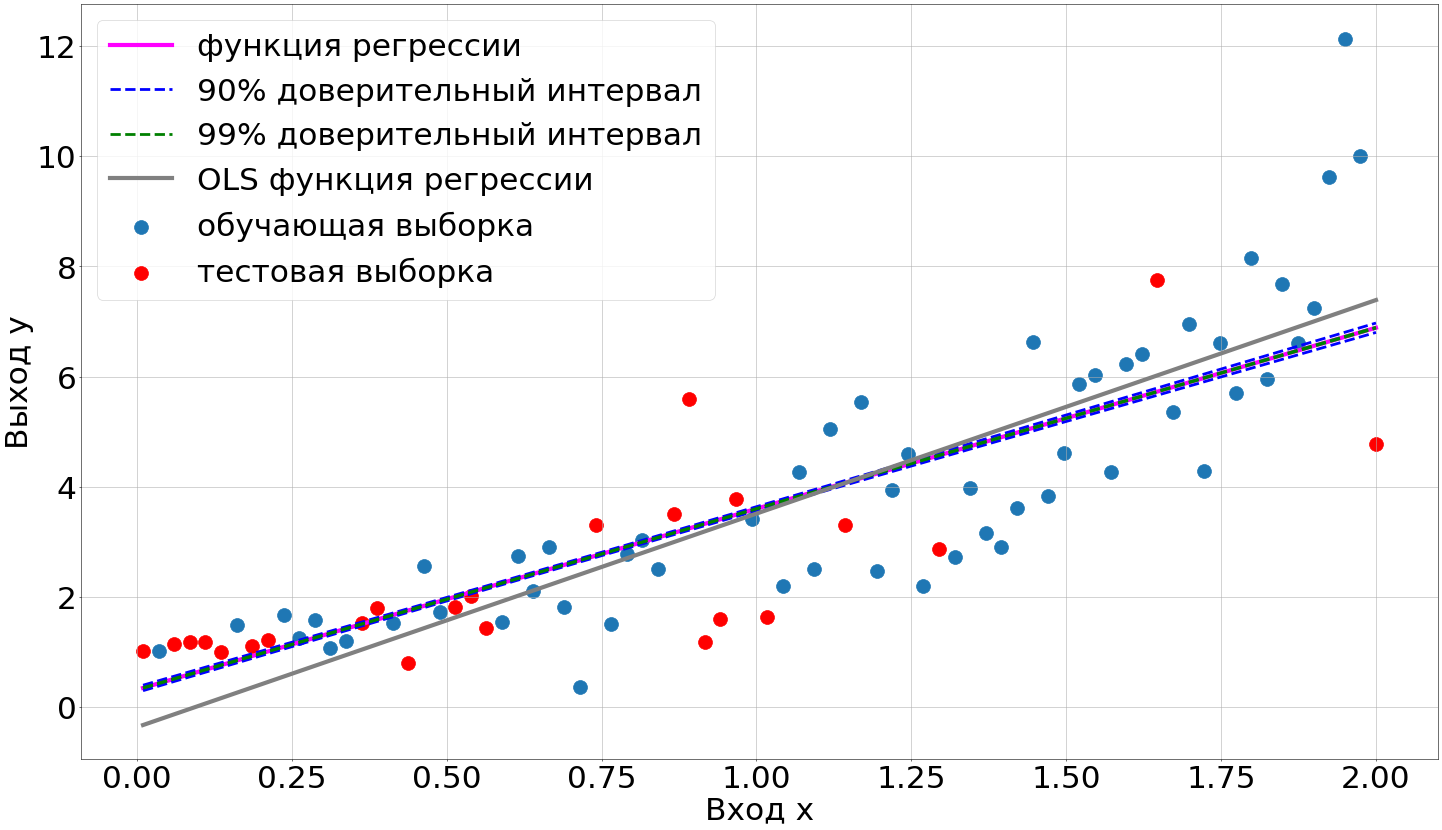

In [ ]:
plt.figure(figsize=(35, 20), dpi=50)
plt.scatter(train_data[0],train_data[1], s=s, label='обучающая выборка')
plt.scatter(test_data[0],test_data[1], s=s, c='r', label='тестовая выборка')
xx = np.array([test_data[0].min(), test_data[0].max()])
yy = regression(xx, params_WLS_f)
plt.plot(xx, yy, c='magenta', label='функция регрессии', linewidth=6)
plt.plot(conf_interval_points, conf_interval_90[0], 'b--', linewidth=4, label='90% доверительный интервал')
plt.plot(conf_interval_points, conf_interval_90[1], 'b--', linewidth=4)
plt.plot(conf_interval_points, conf_interval_99[0], 'g--', linewidth=4, label='99% доверительный интервал')
plt.plot(conf_interval_points, conf_interval_99[1], 'g--', linewidth=4)

xx_ols = np.array([test_data[0].min(), test_data[0].max()])
yy_ols = regression(xx_ols, params_OLS)
plt.plot(xx_ols, yy_ols, c='grey', label='OLS функция регрессии', linewidth=6)

# xx_wls_x = np.array([test_data[0].min(), test_data[0].max()])
# yy_wls_x = regression(xx_wls_x, params_WLS_x)
# plt.plot(xx_wls_x, yy_wls_x, c='orange', label=r'$WLS_x$ функция регрессии', linewidth=6)

plt.xlabel('Вход x')
plt.ylabel('Выход y')
plt.grid(True)
plt.legend(loc='upper left')

##б) веса -  величины, равные 1/x

In [ ]:
inv_x = []
for el in train_data[0]:
  inv_x.append(1/el)
inv_x = np.array(inv_x)
inv_x

array([ 0.65728934,  2.04662205,  0.6916586 ,  0.71664039,  4.2245786 ,
        1.30599451,  1.50389509,  0.62617408,  0.57204965,  0.58041674,
        0.51292573,  0.7877117 ,  3.48322826,  2.96322636,  0.56392037,
        0.82027725,  1.22537006,  0.5560189 ,  0.58903222,  0.74343915,
        0.54086213,  0.59790732,  3.20225439,  0.53358946,  0.95895666,
        1.18867902,  0.66835984,  0.80366471,  0.64657959,  0.6164468 ,
        0.63621326,  0.9147457 ,  0.75763315,  1.44900236,  0.52653749,
       28.41716397,  1.26439834,  0.70392792,  0.83759109,  1.00764805,
        1.62718042,  0.5483358 ,  0.7297672 ,  0.89413448,  3.81825124,
        0.51964249,  0.50638039,  1.56311059,  2.15786975,  6.20578379,
        0.85565158,  0.93632959,  1.39797573,  0.67980965,  1.69672701,
        2.42107302])

In [ ]:
WLS.fit(X=train_data[0].reshape(-1, 1), y=train_data[1], sample_weight=inv_x)

LinearRegression(n_jobs=4)

In [ ]:
params_WLS_x = np.array([WLS.coef_[0], WLS.intercept_])
params_WLS_x

array([3.01673072, 0.62487567])

###Коэффициенты детерминации

In [ ]:
print(R_sqr(train_data[0], train_data[1], params_WLS_x), R_sqr(test_data[0], test_data[1], params_WLS_x))

0.6812065129169195 0.5282224777285294


###Доверительные интервалы функции регрессии

In [ ]:
conf_interval_90 = []
conf_interval_99 = []
conf_interval_points = np.linspace(data[0].min(), data[0].max(), 300)
# conf_interval_points = np.linspace(-10, 10, 500)
for point in conf_interval_points:
  conf_interval_90.append(confidence_interval(point,0.9,test_data[0],test_data[1],params_WLS_x))
  conf_interval_99.append(confidence_interval(point,0.99,test_data[0],test_data[1],params_WLS_x))

In [ ]:
conf_interval_90 = np.array(conf_interval_90).transpose()
conf_interval_99 = np.array(conf_interval_99).transpose()

###Картиночка

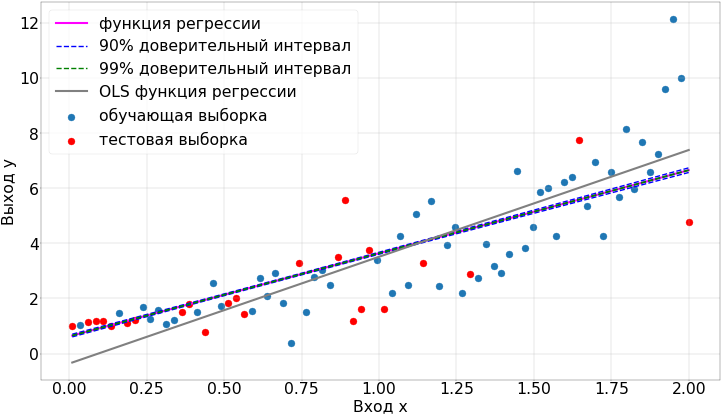

In [ ]:
plt.figure(figsize=(35, 20), dpi=25)
plt.scatter(train_data[0],train_data[1], s=s, label='обучающая выборка')
plt.scatter(test_data[0],test_data[1], s=s, c='r', label='тестовая выборка')
xx = np.array([test_data[0].min(), test_data[0].max()])
yy = regression(xx, params_WLS_x)
plt.plot(xx, yy, c='magenta', label='функция регрессии', linewidth=6)
plt.plot(conf_interval_points, conf_interval_90[0], 'b--', linewidth=4, label='90% доверительный интервал')
plt.plot(conf_interval_points, conf_interval_90[1], 'b--', linewidth=4)
plt.plot(conf_interval_points, conf_interval_99[0], 'g--', linewidth=4, label='99% доверительный интервал')
plt.plot(conf_interval_points, conf_interval_99[1], 'g--', linewidth=4)

xx_ols = np.array([test_data[0].min(), test_data[0].max()])
yy_ols = regression(xx_ols, params_OLS)
plt.plot(xx_ols, yy_ols, c='grey', label='OLS функция регрессии', linewidth=6)

plt.xlabel('Вход x')
plt.ylabel('Выход y')
plt.grid(True)
plt.legend(framealpha=0)
plt.legend(loc='upper left')

#Задание 5

# Исследование остатков моделей на нормальность

##Гистограммы остатков

In [ ]:
res_OLS_train = residuals(train_data[1], regression(train_data[0], params_OLS))
res_OLS_test = residuals(test_data[1], regression(test_data[0], params_OLS))

In [ ]:
res_WLS_f_train = residuals(train_data[1], regression(train_data[0], params_WLS_f))
res_WLS_f_test = residuals(test_data[1], regression(test_data[0], params_WLS_f))

In [ ]:
res_WLS_x_train = residuals(train_data[1], regression(train_data[0], params_WLS_x))
res_WLS_x_test = residuals(test_data[1], regression(test_data[0], params_WLS_x))

In [ ]:
def draw_pdf(ax, func, n_points, func_name, color):
  points = np.linspace(func.ppf(0.0001),
                func.ppf(0.9999), n_points)
  ax.plot(points, func.pdf(points),
       color+'-', lw=1, alpha=0.6, label=func_name)

def draw_hist(ax, values, name):
  loc = np.mean(values)
  scale = np.sqrt(np.var(values))

  hist_params = ax.hist(x=values, bins=round(np.log2(len(values)))-1, density=True,  alpha=0.3, label = 'Наблюдаемые частоты: '+name)
  
  edges = hist_params[1]
  width = edges[1]-edges[0]
  wi = np.full((len(edges)-1,),width)
  hei = []
  for i in range(len(edges)-1):
    hei.append(norm.cdf(edges[i+1], loc=loc, scale=scale)-norm.cdf(edges[i], loc=loc, scale=scale))
  
  # print(hei, len(edges), len(hei))
  
  plt.bar(edges[:-1],height=hei, width=wi, align='edge', edgecolor='r', color='white', alpha=0.5, label='Ожидаемые частоты')
  return hist_params[0], hei, [loc, scale]

In [ ]:
from scipy.stats import norm

OLS

N:  [0.12895981235635443, 1.2970962088892593]


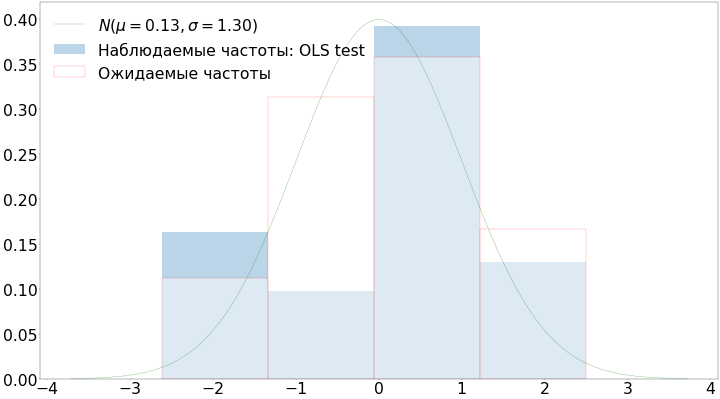

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(35, 20), dpi=25)

h1, h2, distr = draw_hist(ax, res_OLS_test, 'OLS test')
print('N: ',distr)
draw_pdf(ax, norm, 500, r'$N(\mu={0:3.2f}, \sigma={1:3.2f}$)'.format(distr[0], distr[1]), 'g')
ax.legend(loc='upper left', frameon=False)
plt.show()

In [ ]:
from scipy.stats import chisquare

In [ ]:
print(h1,h2)
chisquare(h1,h2,2)

[0.16305826 0.09783495 0.39133982 0.13044661] [0.11180774996567121, 0.3128870883324671, 0.3573402006189713, 0.1667116467259746]


Power_divergenceResult(statistic=0.18242462657916425, pvalue=0.6692977819576519)

N:  [-4.916701966197122e-16, 1.3409702239984558]


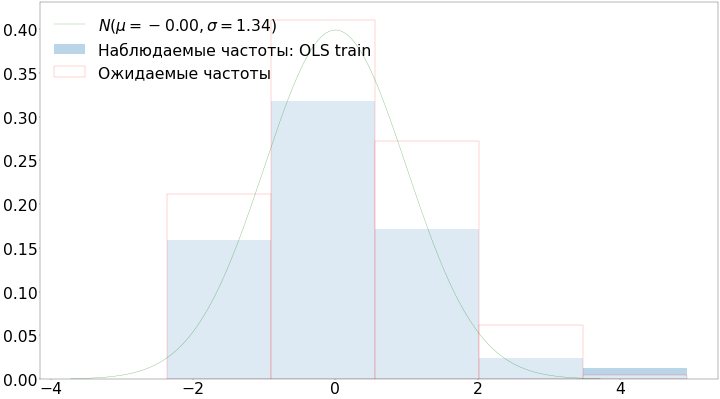

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(35, 20), dpi=25)

h1, h2, distr = draw_hist(ax, res_OLS_train, 'OLS train')
print('N: ',distr)
draw_pdf(ax, norm, 500, r'$N(\mu={0:3.2f}, \sigma={1:3.2f}$)'.format(distr[0], distr[1]), 'g')
ax.legend(loc='upper left', frameon=False)
plt.show()

In [ ]:
print(h1,h2)
chisquare(h1,h2,2)

[0.15892948 0.31785896 0.17115482 0.02445069 0.01222534] [0.21132424464628932, 0.4108886298163019, 0.27265354852792145, 0.06142970048479679, 0.004625574618018158]


Power_divergenceResult(statistic=0.10658433338283003, pvalue=0.9481029679054166)

WLS_f

N:  [-0.1555579452219739, 1.1647553005586988]


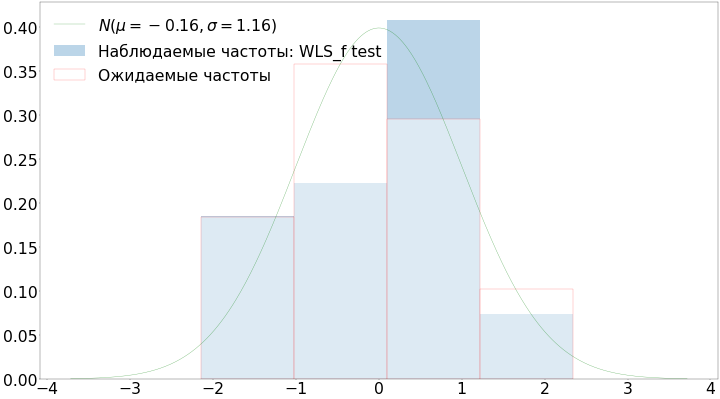

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(35, 20), dpi=25)

h1, h2, distr = draw_hist(ax, res_WLS_f_test, 'WLS_f test')
print('N: ',distr)
draw_pdf(ax, norm, 500, r'$N(\mu={0:3.2f}, \sigma={1:3.2f}$)'.format(distr[0], distr[1]), 'g')
ax.legend(loc='upper left', frameon=False)
plt.show()

In [ ]:
print(h1,h2)
chisquare(h1,h2,2)

[0.18568165 0.22281798 0.40849963 0.07427266] [0.1842580570459233, 0.3582249526659473, 0.29499387622419004, 0.10277095126107161]


Power_divergenceResult(statistic=0.10277058329181078, pvalue=0.7485298226465369)

N:  [1.5860328923216522e-16, 1.3797992954459426]


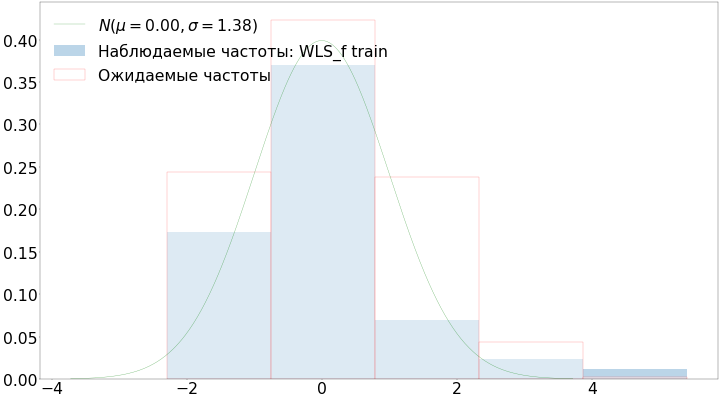

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(35, 20), dpi=25)

h1, h2, distr = draw_hist(ax, res_WLS_f_train, 'WLS_f train')
print('N: ',distr)
draw_pdf(ax, norm, 500, r'$N(\mu={0:3.2f}, \sigma={1:3.2f}$)'.format(distr[0], distr[1]), 'g')
ax.legend(loc='upper left', frameon=False)
plt.show()

In [ ]:
print(h1,h2)
chisquare(h1,h2,2)

[0.173705   0.37057066 0.069482   0.02316067 0.01158033] [0.24402902592153433, 0.4236681731525964, 0.23861401838037222, 0.04324009942733453, 0.0024716369222704815]


Power_divergenceResult(statistic=0.18969546830894152, pvalue=0.9095114114493894)

WLS_x

N:  [-0.28504320725215543, 1.1263255070066138]


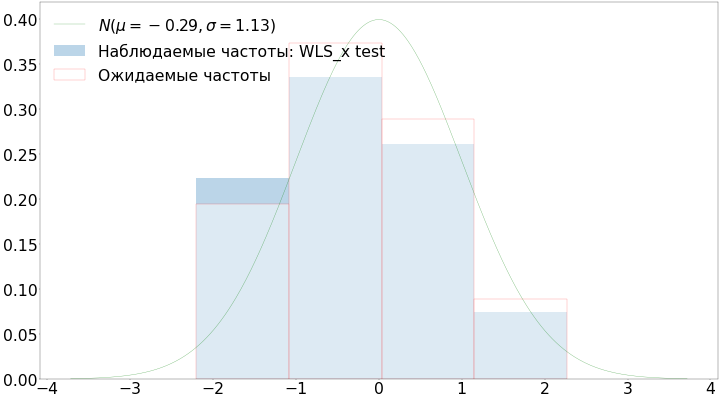

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(35, 20), dpi=25)

h1, h2, distr = draw_hist(ax, res_WLS_x_test, 'WLS_x test')
print('N: ',distr)
draw_pdf(ax, norm, 500, r'$N(\mu={0:3.2f}, \sigma={1:3.2f}$)'.format(distr[0], distr[1]), 'g')
ax.legend(loc='upper left', frameon=False)
plt.show()

In [ ]:
print(h1,h2)
chisquare(h1,h2,2)

[0.22315494 0.33473241 0.26034743 0.07438498] [0.19408670814671458, 0.3729755592543501, 0.2881672842296309, 0.08934027253285093]


Power_divergenceResult(statistic=0.013464018669439524, pvalue=0.907625153381337)

N:  [-1.6653345369377348e-16, 1.421930456807127]


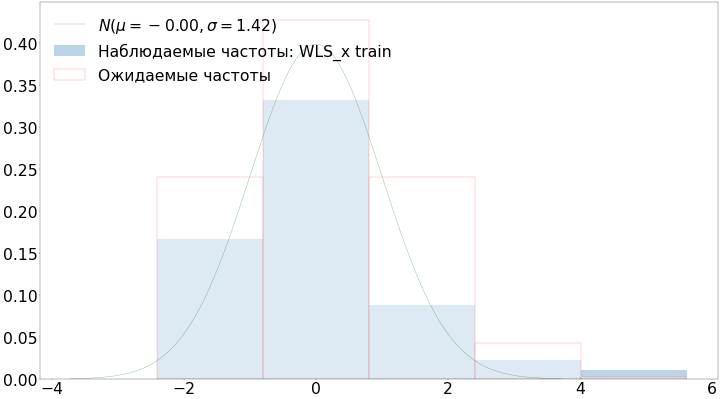

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(35, 20), dpi=25)

h1, h2, distr = draw_hist(ax, res_WLS_x_train, 'WLS_x train')
print('N: ',distr)
draw_pdf(ax, norm, 500, r'$N(\mu={0:3.2f}, \sigma={1:3.2f}$)'.format(distr[0], distr[1]), 'g')
ax.legend(loc='upper left', frameon=False)
plt.show()

In [ ]:
print(h1,h2)
chisquare(h1,h2,2)

[0.16653289 0.33306577 0.08881754 0.02220438 0.01110219] [0.24065388424647693, 0.42832109364930393, 0.24127954625668557, 0.04264126457684503, 0.0023142048431805673]


Power_divergenceResult(statistic=0.1835188177803298, pvalue=0.9123246203356077)